In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
using LinearAlgebra

 Activating new environment at `~/Documents/julia_program_files/Project.toml`
   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
No Changes to `~/Documents/julia_program_files/Project.toml`
No Changes to `~/Documents/julia_program_files/Manifest.toml`


# Question 1: Implicit Integrators (25 pts)
In this question we'll be taking a deeper look into implicit integration techniques, and some of the advantages they bring.

## Part (a): Implicit Midpoint (3 pts)
Implement implicit midpoint integration for the simple pendulum with $m = l = 1$ and $g = 9.81$:
$$ x_{n+1} = x_n + h f\left(\frac{x_{n+1} + x_n}{2}\right) $$

In [2]:
# TASK: Implement the `implicit_midpoint_pendulum!` function
"""
    x2 = implicit_midpoint_pendulum!(x2, x1, h; [m,l,g])

Evaluate the discrete pendulum dynamics with mass `m`, length `l`, and gravity `g` using
implicit midpoint:

``x_{n+1} = x_n + h f\\left(\\frac{x_{n+1} + x_n}{2}\\right)``
"""

function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ̇ = x[2]
    
    θ̈ = -(g/l)*sin(θ)
    
    return [θ̇; θ̈]
end

function implicit_midpoint_pendulum(x2, x1, h)
    return (x1+h*pendulum_dynamics((x2+x1)/2))
end

implicit_midpoint_pendulum (generic function with 1 method)

In [3]:
x1 = [1,1.] 
x2 = [2,2.] 
h = 0.1
out = implicit_midpoint_pendulum(x2,x1,h)

2-element Array{Float64,1}:
 1.15
 0.021457418141422435

## Part (b): Solve using Newton's Method (10 pts)
Use Newton's method to solve for $x_{n+1}$ with initial guess $x_{n+1} = x_n$. Solve such that the 2-norm of the residual is less than 1e-6. 

**NOTE**: It should take 5 iterations or less. If it's taking more iterations than that, you're doing something wrong.

In [4]:
# TASK: Complete the following function
"""
    implicit_midpoint_solve!(x2,x1,h)

Find the `x2` that satisfies implicit midpoint integration for the pendulum dynamics. 

Should modify `x2` in-place and return a vector of 2-norm residuals. The input value of `x2`
should be used as the initial guess.
"""

using ForwardDiff

function implicit_midpoint_solve!(x2, x1, h; ϵ=1e-7)::Vector{Float64}
    # TODO: Implement this function. Feel free to add optional input arguments as needed
    x = [x2[1];x2[2]]
    residuals = Float64[]
    res = x - implicit_midpoint_pendulum(x, x1, h)
#     println(norm(res))
    residuals = [norm(res)]
    while norm(res) > ϵ
        f0 = x - implicit_midpoint_pendulum(x, x1, h)
#         J = [1 -h/2; 9.81*h/2*cos(x2[1]) 1]
        J = ForwardDiff.jacobian(x -> x - implicit_midpoint_pendulum(x, x1, h), x)
        
        dx = -J\f0
        
        x = x + dx
        res = x - implicit_midpoint_pendulum(x, x1, h)
        residuals = [residuals norm(res)]
    end
    x2[1] = x[1]
    x2[2] = x[2]
    return vec(residuals)
end

implicit_midpoint_solve! (generic function with 1 method)

In [5]:
x1 = [1,1.] 
x2 = [2,2.] 
h = 0.1
res = implicit_midpoint_solve!(x2, x1, h)

# @show x2
# @show x2 ≈ [1.0579750727230095, 0.15950145446019248]

4-element Array{Float64,1}:
 2.1533998115137853
 0.10650960705931933
 2.9022955960744667e-6
 2.1210781103223385e-15

## Part (c): Energy Analysis (2 pts)
Simulate with $h=0.1$ for 1 hour and plot the total energy of the system vs time:
$$ E = \frac{1}{2} m l^2 \omega^2 + m g l (1 - \cos \theta) $$

Start the simulation with an initial state of 45 degrees and zero velocity.

In [6]:
# TASK: Compute the energy of the system. Store the result in the vector `energy_implicit::Vector{Float64}`
using PyPlot

function pendulum_forward_implicit(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    energy_hist = zeros(length(t))
    x_hist[:,1] .= x0
    energy_hist[1] = 0.5*x0[2]^2 + 9.81*(1-cos(x0[1]))
    
    for k = 1:(length(t)-1)
        x = x_hist[:,k]
        fun(x, x_hist[:,k], h)    
        x_hist[:,k+1] = x
#         println(x_hist[:,k+1])
        energy_hist[k+1] = 0.5*x_hist[:,k][2]^2 + 9.81*(1-cos(x_hist[:,k][1]))
    end
    
    return x_hist, t, energy_hist
end

energy_implicit = zeros(36001);
Tf = 3600
h = 0.1
x0 = [pi/4;0.0]
x_hist, t, energy_implicit = pendulum_forward_implicit(implicit_midpoint_solve!, x0, Tf, h)  

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


([0.7853981633974483 0.7513107220090732 … 0.46919378966690894 0.2611797884075531; 0.0 -0.6817488277675015 … -1.9049708020058427 -2.255309223181273], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  3599.1, 3599.2, 3599.3, 3599.4, 3599.5, 3599.6, 3599.7, 3599.8, 3599.9, 3600.0], [2.8732824765599685, 2.8732824765599685, 2.8732937275331656, 2.8735560824904187, 2.87442995764877, 2.875741558724905, 2.8766126633937374, 2.8762969454497953, 2.8750755776581203, 2.873908575945493  …  2.8764102217608967, 2.8765626030773777, 2.8755768417167866, 2.874283052902132, 2.8734961352377946, 2.8732906019879563, 2.8732860128284794, 2.8733083046372943, 2.8736346922878315, 2.874592970947477])

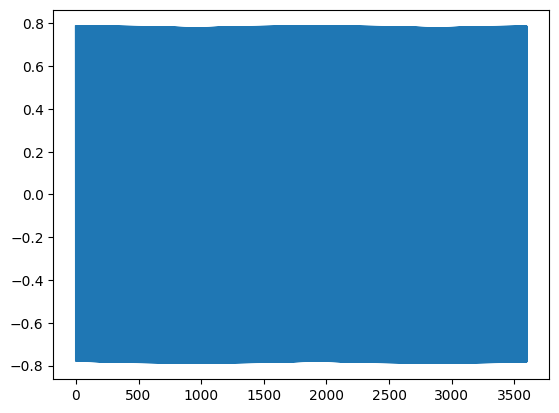

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f5510e190>

In [7]:
plot(t, x_hist[1,:])

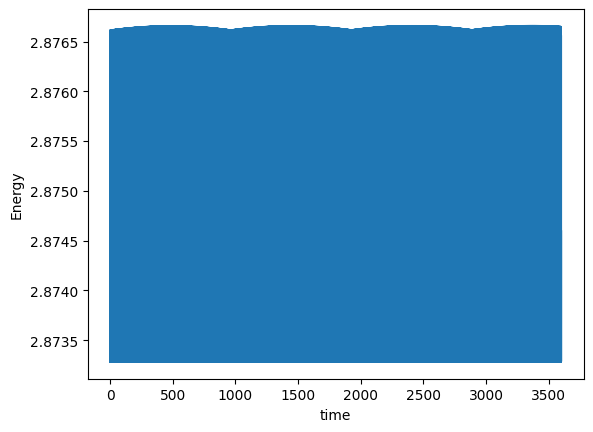

(36001,)
(36001,)


PyObject Text(24.0, 0.5, 'Energy')

In [8]:
println(size(t))
println(size(energy_implicit))
plot(t, energy_implicit)
xlabel("time")
ylabel("Energy")

## Part (d): RK4 Comparison (5 pts)
Compare the energy behavior of the implicit midpoint integrator with a 4th order Runge Kutta integrator.

In [9]:
# TASK: implement a 4th order Runge Kutta integrator for the pendulum (3 pts)
"""
    rk4(x, h)

Integrate the pendulum dynamics with a 4th Order Runge Kutta method at states `x` and time step `h`.
"""
function rk4(x, h)
    # TODO: implement rk4
    f1 = pendulum_dynamics(x)
    f2 = pendulum_dynamics(x + 0.5*h*f1)
    f3 = pendulum_dynamics(x + 0.5*h*f2)
    f4 = pendulum_dynamics(x + h*f3)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

rk4

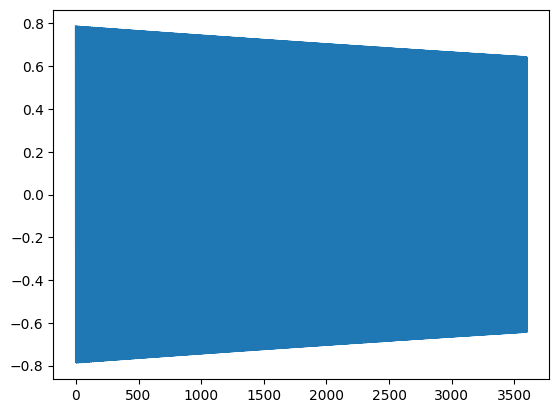

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f46e99a00>

In [10]:
# TASK: Compute the energy behavior of rk4. Store the result in `energy_rk4::Vector{Float64}` (1 pt)
# TASK: Generate a plot of energy vs time comparing implicit midpoint with rk4 (1 pt)

function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    energy_hist = zeros(length(t))
    x_hist[:,1] .= x0
    energy_hist[1] = 0.5*x0[2]^2 + 9.8*(1-cos(x0[1]))
    
    for k = 1:(length(t)-1)
        
        x_hist[:,k+1] = fun(x_hist[:,k], h)    
#         println(x_hist[:,k+1])
        energy_hist[k+1] = 0.5*x_hist[:,k][2]^2 + 9.8*(1-cos(x_hist[:,k][1]))
    end
    return x_hist, t, energy_hist
end

energy_rk4 = zeros(36001)
Tf = 3600
h = 0.1
x0 = [pi/4;0.0]
x_hist, t, energy_rk4 = pendulum_rk4(rk4, x0, Tf, h)
plot(t, x_hist[1,:])



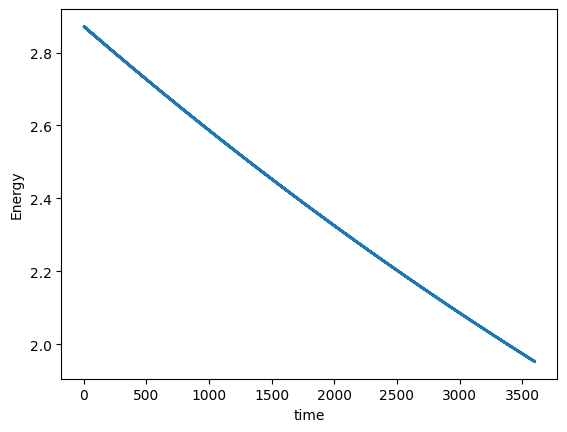

(36001,)
(36001,)


PyObject Text(24.000000000000007, 0.5, 'Energy')

In [11]:
println(size(t))
println(size(energy_implicit))
plot(t, energy_rk4)
xlabel("time")
ylabel("Energy")

## Part (e): Evaluating the Jacobian (5 pts)
Computing the Jacobian for an explicit integrator like RK4 is straightforward, since it's just a basic application of the chain rule (you should do this for practice, and can check your result with ForwardDiff). 

Computing the Jacobian for an implicit integrator is not as trivial since we use Newton's method to compute the next step. However, we can use the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem), which can be easily derived by taking a 1st order Taylor series expansion of $f(x,y) = 0$:
$$ f(x,y) = 0 \implies f(x + \Delta x, y + \Delta y) \approx f(x,y) + \frac{\partial f}{\partial x} \Delta x + \frac{\partial f}{\partial y} \Delta y = 0 $$
Dropping $f(x,y)$ (since it's zero) and solving for $\Delta x$ we obtain an expression for our Jacobian:
$$ \Delta x = -\frac{\partial f}{\partial x}^{-1} \frac{\partial f}{\partial y} \Delta y $$

Use this to compute the Jacobian of the implicit integrator, evaluated at $\theta = \omega = 0$. 

In [12]:
# TASK: Compute the Jacobian of the implicit midpoint integrator for h = 0.1. (3 pts)
#       Store the result in `Amid::Matrix{Float64}` of size (2,2)
x2 = [0.0;0.0]
h=0.1
Amid = zeros(2,2)
dfx = [1 -h/2; 9.81*h/2*cos(x2[1]) 1]
dfy = [-1 -h/2; 9.81*h/2*cos(x2[1]) -1]
Amid = -dfx\dfy

2×2 Array{Float64,2}:
  0.952124  0.0976062
 -0.957517  0.952124

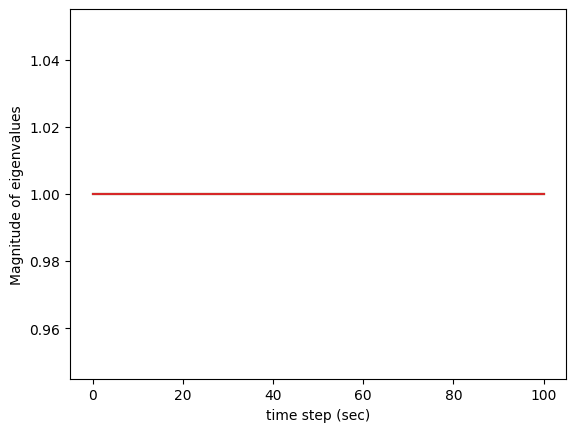

PyObject Text(24.00000000000002, 0.5, 'Magnitude of eigenvalues')

In [13]:
# TASK: Compute the magnitude of the eigenvalues of A for 0 ≤ h ≤ 1.  (1 pt)
#       Store the result in `eigs_implicit::Matrix{Float64}` of size (101,2)
hs = range(0,100, length=101)
eigs_implicit = zeros(101,2)

for k = 1:size(eigs_implicit,1)
    dfx = [1 -hs[k]/2; 9.81*hs[k]/2*cos(x2[1]) 1]
    dfy = [-1 -hs[k]/2; 9.81*hs[k]/2*cos(x2[1]) -1]
    Amid = -dfx\dfy
    eigs_implicit[k,:] = norm.(eigvals(Amid))
end
plot(hs,eigs_implicit)


# TASK: Plot the eigenvalues vs time step (1 pt)
plot(hs, eigs_implicit)
xlabel("time step (sec)")
ylabel("Magnitude of eigenvalues")

### NOTE:
Obviously something special is going on here. Implicit midpoint is a "symplectic" integrator. That means it conserves energy (up to numerical roundoff/truncation error). Implicit midpoint is also the simplest "collocation" method. More about those later...